In [1]:
import sys, os
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('../modules')
from nsw.nsw_classifier import NSWClassifier
import nsw.data_gen as dg

# 1. Synthetic dataset - proof of concept

Classifier graph is build in 10.616s


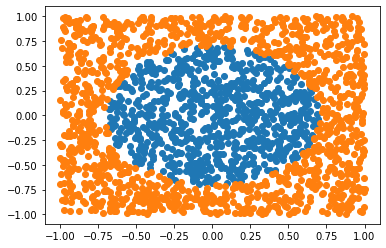

In [2]:
classifier = NSWClassifier()
data = dg.gen(N=2000, border=0.7)
classifier.build_navigable_graph(data, attempts=20)

# show classes
cls0 = np.array([r[0] for r in data if r[1] == 0])
cls1 = np.array([r[0] for r in data if r[1] == 1])
plt.scatter(cls0[:,0], cls0[:,1])
plt.scatter(cls1[:,0], cls1[:,1])
plt.show()

In [3]:
test = dg.gen(N=200, border=0.7)

path, knn = 0, 0
for t in test:
    path += classifier.classify_by_path(t[0], attempts=1) == t[1]
    knn += classifier.classify_knn(t[0], attempts=1) == t[1]
    
print(f"Path classifier accuracy = {100 * path / len(test):.2f}%")
print(f"Knn classifier accuracy = {100 * knn / len(test):.2f}%")

Path classifier accuracy = 98.50%
Knn classifier accuracy = 98.50%


# 2. Simple case: MINST

In [4]:
!python -m pip install mnist

In [5]:
from sklearn import datasets
import random

digits = datasets.load_digits()
X, Y = [x.flatten() for x in digits.images], digits.target
XY = list(zip(X, Y))
random.shuffle(XY)
train, test = XY[:4 * len(XY) // 5], XY[4 * len(XY) // 5:]

minst_classifier = NSWClassifier()
minst_classifier.build_navigable_graph(train, attempts=20)

Classifier graph is build in 64.279s


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
MNIST: Path classifier accuracy = 99.17%
MNIST: Knn classifier accuracy = 97.22%


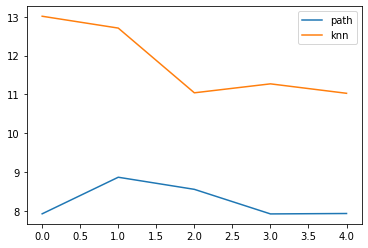

In [6]:
import time

path_times, knn_times = [], []
path, knn = 0, 0
times = 5

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in test:
        path += minst_classifier.classify_by_path(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    path_times.append(f - s)
    
    s = time.perf_counter()
    for t in test:
        knn += minst_classifier.classify_knn(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    knn_times.append(f - s)

        
print(f"MNIST: Path classifier accuracy = {100 * path / len(test) / times:.2f}%")
print(f"MNIST: Knn classifier accuracy = {100 * knn / len(test) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()

# 100 leaves

[dataset](https://archive.ics.uci.edu/ml/datasets/One-hundred+plant+species+leaves+data+set)

```
@inproceedings{Mallah2013PLANTLC,
  title={PLANT LEAF CLASSIFICATION USING PROBABILISTIC INTEGRATION OF SHAPE, TEXTURE AND MARGIN FEATURES},
  author={Charles D. Mallah and James S. Cope and James Orwell},
  year={2013}
}
```

In [15]:
import random

texture_file = "../data/100leaves/data_Tex_64.txt"
shape_file = "../data/100leaves/data_Sha_64.txt"
margin_file = "../data/100leaves/data_Mar_64.txt"

dataset = []
for line in open(texture_file):
    parts = line.strip().split(',')
    cls, vect = parts[0], list(map(float, parts[1:]))
    dataset.append((vect, cls))
    
random.shuffle(dataset)

train, test = dataset[:9 * len(dataset) // 10], dataset[9 * len(dataset) // 10:]
print(f"train {len(train)}; test {len(test)}")

train 1439; test 160


In [16]:
leaves_classifier = NSWClassifier()
leaves_classifier.build_navigable_graph(train, attempts=10)

Classifier graph is build in 73.805s


iteration 0
iteration 1
iteration 2
100LEAVES: Path classifier accuracy = 75.00%
100LEAVES: Knn classifier accuracy = 43.12%


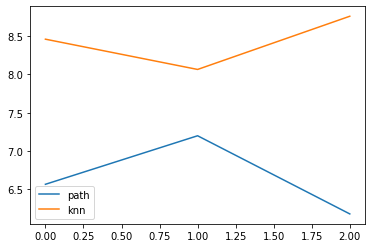

In [18]:
import time

path_times, knn_times = [], []
path, knn = 0, 0
times = 3

for i in range(times):
    print(f"iteration {i}")
    s = time.perf_counter()
    for t in test:
        path += leaves_classifier.classify_by_path(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    path_times.append(f - s)
    
    s = time.perf_counter()
    for t in test:
        knn += leaves_classifier.classify_knn(t[0], attempts=1) == t[1]
    f = time.perf_counter()
    knn_times.append(f - s)

        
print(f"100LEAVES: Path classifier accuracy = {100 * path / len(test) / times:.2f}%")
print(f"100LEAVES: Knn classifier accuracy = {100 * knn / len(test) / times:.2f}%")

plt.plot(path_times, label="path")
plt.plot(knn_times, label="knn")
plt.legend()
plt.show()